In [ ]:
#https://towardsdatascience.com/tutorial-on-variational-graph-auto-encoders-da9333281129
#https://www.machinecurve.com/index.php/2019/12/24/what-is-a-variational-autoencoder-vae/
#https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/
#https://github.com/pytorch/examples/blob/master/vae/main.py
# http://adamlineberry.ai/vae-series/vae-code-experiments

In [ ]:
!pip install pickle5
!cp "/content/drive/My Drive/Colab Notebooks/AMPsNonAMPs_df.plk" .

     |████████████████████████████████| 133kB 4.8MB/s eta 0:00:01
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218607 sha256=df19077d1489c38741c59df3cc939b89fba7d0ec2a3cf703930f647653686f11
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})

Set system to use GPU

In [ ]:
#my_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your tensors datset
#train_loader = DataLoader(my_dataset, batch_size=100) # We don’t want our whole training data to be loaded into CPU/GPU tensors
torch.cuda.empty_cache()
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpu = 0
device = torch.device(gpu if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(device)

cuda:0


Load data from plk format, and drop duplicated records

In [ ]:
import pickle5 as pickle
with open( "AMPsNonAMPs_df.plk", 'rb') as file:
    df = pickle.load(file)
df.drop_duplicates(subset=['Sequence'],inplace=True)
df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42439,UniRef50_B2ABU5 Podospora anserina S mat+ geno...,MKWKAIIAAYGM,12,1,"[0.04739842936396599, 0.01943567767739296, -0...."
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."


# Split label / Test/ Training set

In [ ]:
AMPs_df = df[df["class"]==0]
NonAMPs_df = df[df["class"]==1]

In [ ]:
NonAMPs_df

,ID,Sequence,length,class,reps
21226,UniRef50_A0A672ZWI7 Ig-like domain-containing ...,MVIHQRHTSDESFSSSPVEIRITAATPIPELAEERSAEKPPAVTET...,189,1,"[0.010885448195040226, -0.14450328052043915, 0..."
21227,UniRef50_A0A3Q2PZR6 Uncharacterized protein n=...,MSTQAPTFTQPLQSVVALEGSAATFEAQVSGSPVPEVSWFRDGQVL...,295,1,"[0.008847306482493877, -0.18223115801811218, 0..."
21228,UniRef50_V9IMB4 Titin n=21 Tax=Apis TaxID=7459...,MWMEVGRVNADTQKLNIRDLQENHMYLIRIFAKNEVGLSDPLESDE...,121,1,"[0.007636816706508398, -0.014043575152754784, ..."
21229,UniRef50_B4IRR3 GL21409 (Fragment) n=18 Tax=Dr...,IIHPLEDVSVTKGENAIFELELSKGDALVKWFKNGKELVFNDRVQL...,320,1,"[0.005961225368082523, -0.24985796213150024, 0..."
21230,UniRef50_UPI00083D1E21 titin-like n=26 Tax=Apo...,HDFGIVILDILYCYEENSGVYECRAFNKYGEDTTKATLKCFSKASL...,65,1,"[0.012905298732221127, -0.050979312509298325, ..."
...,...,...,...,...,...
42439,UniRef50_B2ABU5 Podospora anserina S mat+ geno...,MKWKAIIAAYGM,12,1,"[0.04739842936396599, 0.01943567767739296, -0...."
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."


In [ ]:
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
21221,LFB0114|milkampdb,KKWQWRMKKLG,11,0,"[0.05450811609625816, -0.012593518942594528, -..."
21222,"CAA0039,CAA0041,CAA0040|milkampdb",LRLKKYNVPQL,11,0,"[0.05241929367184639, -0.01412256807088852, -0..."
21223,LFB0117|milkampdb,RRAAARAKKAG,11,0,"[0.04833624139428139, -0.004618115723133087, -..."
21224,LFB0115|milkampdb,RRWQRWMKKLG,11,0,"[0.04557448625564575, -0.016351114958524704, -..."


In [ ]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())
X_NonAMPs = np.array(NonAMPs_df['reps'].to_list())
y_NonAMPs = np.array(NonAMPs_df['class'].to_list())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 Create Tensor for AMPs

In [ ]:
Amps_train = [] 
Amps_test = [] 
t = torch.Tensor(X_train).cuda() # if no cuda is available then remove .cuda()
j = torch.Tensor(X_test).cuda()
#t = torch.Tensor([[0.0032203220762312412, 0.07328620553016663, 0.03960951417684555, -0.08139611780643463, -0.09766422212123871, -0.009298615157604218, 0.14109456539154053, -0.014705468900501728, -0.0023602822329849005, 0.017337778583168983, -0.07331045717000961, -0.00021124011254869401, 0.0193979199975729, -0.4777616262435913, 0.003328051185235381, 0.00010637283412506804, 0.016471300274133682, -0.01661418378353119, 0.321921706199646, -0.0038946345448493958, -0.01604468934237957, 0.08834319561719894, 0.16474846005439758, -0.0855826810002327, 0.04877813905477524, -0.13036441802978516, -0.29385948181152344, 0.020544439554214478, -0.2915758192539215, -0.03236082196235657, -0.13796989619731903, -0.11526091396808624, 0.02499699406325817, -0.060519229620695114, 0.1600552797317505, -0.02140066586434841, 0.003806919790804386, -0.05789140239357948, 0.015673436224460602, 3.203899905201979e-05, -0.012392737902700901, 0.0035533313639461994, -0.0833122655749321, -0.00949341244995594, 0.0170972291380167, 0.11582595854997635, -0.19075830280780792, 0.05445372313261032, 0.22365902364253998, 0.013416478410363197, 0.059177231043577194, -0.0342712365090847, 0.0787702426314354, -0.041220974177122116, 0.008113911375403404, -0.08956985920667648, 0.03159015253186226, -0.1665271520614624, -0.02659621462225914, -0.0032638763077557087, 0.016763683408498764, -0.16329973936080933, -0.08902140706777573, -0.006265510339289904, 0.8336946964263916, -0.013393633998930454, 0.01251889020204544, -0.07976581156253815, 0.10190673172473907, -0.010683612897992134, -0.034557703882455826, -0.04732334613800049, 0.031698454171419144, 0.004806730896234512, -0.006145419552922249, -0.10292720049619675, -0.10138313472270966, -0.011501520872116089, 0.13311974704265594, -0.005901868920773268, -0.17030276358127594, 0.08400975167751312, 0.26025688648223877, 0.11331162601709366, 0.8473144769668579, -0.0031422325409948826, 0.006838327273726463, -0.1397782862186432, 0.2377057820558548, 0.05232403799891472, -0.5166886448860168, -0.14724187552928925, 0.0003958282177336514, 0.16586540639400482, -0.26500675082206726, 0.050287406891584396, 0.02921442687511444, 0.0002658162557054311, -0.025751585140824318, 0.0015113056870177388, 0.0006567726959474385, -0.02740096114575863, -0.10653629153966904, -0.0037283403798937798, -0.0015316798817366362, -0.3651998043060303, 0.04271034151315689, -0.010536671616137028, 0.08756453543901443, -0.001579746836796403, -0.07266876101493835, 0.16107270121574402, -0.0007447779062204063, 0.021898025646805763, 0.05523692071437836, -0.11496037244796753, 0.011109394952654839, -0.0001926458498928696, -0.033206675201654434, 0.004074163734912872, 0.083738774061203, -0.27825555205345154, -0.21392866969108582, 0.36775389313697815, -0.12591545283794403, -0.007120863534510136, 0.00028197208303026855, -0.34637555480003357, 0.0935337245464325, 0.17949023842811584, -0.005405621137470007, 0.017821067944169044, 0.047345343977212906, 0.0017071382608264685, 0.08962036669254303, 0.0064345113933086395, 0.01826142892241478, -0.009431224316358566, 0.057465363293886185, 0.017759351059794426, -0.01513376273214817, 0.5662921071052551, -0.011165115050971508, -0.43639129400253296, 0.0011690370738506317, -0.0030380364041775465, 0.025661371648311615, -0.025163227692246437, -0.24275994300842285, 0.024508574977517128, -0.27138400077819824, 0.19132445752620697, 0.20218561589717865, -0.008159147575497627, 0.0015026485780254006, 0.001862446661107242, -0.10190900415182114, 0.432892382144928, 0.3359145224094391, 0.07445476949214935, -0.2720832824707031, 0.04505674168467522, -0.0024361396208405495, -0.07826432585716248, -0.005310654174536467, 0.1387561410665512, -0.0704239085316658, -0.011105314828455448, 0.021909072995185852, -0.05641596019268036, -0.04828498512506485, -0.1557556837797165, -0.09730123728513718, -0.02591383270919323, -0.27105268836021423, 0.018683476373553276, -0.04502935707569122, 0.11156624555587769, -0.4646322429180145, -0.012862489558756351, -0.016657283529639244, 0.04052335023880005, 0.0022589501459151506, -0.003912036772817373, -0.04424455389380455, 0.004950905684381723, 0.08237173408269882, 0.0051269978284835815, 0.02907947637140751, -0.8579010963439941, 0.05923711135983467, -0.06098068132996559, -0.0004614625358954072, -0.16358913481235504, 0.03773731738328934, 0.22071672976016998, -0.035803839564323425, -0.10898273438215256, -0.11003704369068146, -0.025148237124085426, -0.006568992044776678, 0.01437890250235796, -0.03479262441396713, -0.08759799599647522, 0.17181140184402466, 0.002412047004327178, -0.1720762550830841, -0.05181194469332695, 0.004983679857105017, 0.0865708738565445, 0.03294239565730095, 0.0011258024023845792, -0.0019066217355430126, 0.03390364721417427, 0.0029501733370125294, -0.15214407444000244, 0.6623154282569885, -0.0001159868625109084, -0.38904786109924316, -0.040901802480220795, -0.006271032616496086, 0.020380673930048943, 0.025547916069626808, -0.35876646637916565, -0.09176170080900192, -0.1022493839263916, -0.09636074304580688, -0.06285925209522247, 0.04048386588692665, 0.032845448702573776, -0.1504698544740677, 0.004004711285233498, 0.04180893674492836, 0.13556618988513947, -0.030991841107606888, 0.1636238843202591, -0.0062639047391712666, -0.309492826461792, 0.038794226944446564, 0.056988783180713654, 0.047089021652936935, -0.12141487747430801, 0.02154642529785633, -0.03454327955842018, -0.16699065268039703, 0.09544505178928375, -0.040683627128601074, -0.04131947457790375, 0.0062826164066791534, -0.014262004755437374, 0.011097332462668419, -0.08634749054908752, -0.2081945240497589, 0.07545589655637741, -0.035123784095048904, -0.0032908127177506685, 0.502315104007721, -0.09305773675441742, 0.009269625879824162, 9.361719276057556e-05, -0.16668105125427246, 0.04725411906838417, -0.04220367223024368, 0.0859282836318016, -0.04170325770974159, 0.0333159863948822, -0.09016668051481247, -0.1666790246963501, -0.034355279058218, 0.3541845679283142, -0.030462289229035378, 0.04661203548312187, -0.0007608533487655222, -0.0425880029797554, -0.0681334137916565, -0.12053438276052475, 0.0008545778109692037, 0.0021914883982390165, 0.14698442816734314, 0.1730785220861435, -0.008139412850141525, 0.1223134845495224, 0.0007963928510434926, -0.03529035672545433, -0.0011281216284260154, -0.081780806183815, -0.009094374254345894, -0.031332068145275116, 0.01177632249891758, 0.17590837180614471, 0.08766099065542221, -0.2491980344057083, -0.2866690754890442, -0.12618346512317657, -0.025625798851251602, 0.11108372360467911, 0.041301462799310684, 0.12827864289283752, 0.02510877512395382, -0.05107996240258217, -0.0038695079274475574, 0.08898330479860306, -0.1426931917667389, -0.04014902561903, 0.22198407351970673, -0.021846814081072807, 0.11713698506355286, -0.06111558899283409, -0.2395903468132019, 0.017637059092521667, -0.06446822732686996, -0.6089999079704285, -0.020811034366488457, 0.11678158491849899, 0.015620449557900429, -0.01005467213690281, -0.09292152523994446, 0.5850170850753784, 0.11439520865678787, -0.01244972925633192, 0.13709622621536255, -0.05035680532455444, 0.20356634259223938, 0.0006830507190898061, 0.07063455134630203, 0.3020612597465515, -0.19668477773666382, 0.05142415687441826, -0.052556052803993225, -0.008591889403760433, 0.32548022270202637, 0.010337666608393192, 0.057509150356054306, -0.01038910448551178, -0.5652627944946289, 0.09033677726984024, -0.3099823594093323, 0.11492861062288284, -0.015748562291264534, -0.6118812561035156, -0.27164706587791443, 0.2802169919013977, -0.11672396957874298, 0.031609077006578445, -0.06203407049179077, -0.04839092120528221, 0.01460433192551136, 0.004780988208949566, 0.20750313997268677, 0.4071139395236969, -0.6551696062088013, 0.17856550216674805, 5.409360528574325e-05, 0.48021626472473145, 0.10422950237989426, -0.0010132736060768366, -0.051490239799022675, -0.0027501778677105904, 0.23588526248931885, 0.01024555042386055, 0.0377357043325901, 0.011917971074581146, 0.02554326131939888, 0.029453516006469727, -0.24686866998672485, 0.004470947664231062, -0.012751328758895397, -0.10452054440975189, -0.011011444963514805, -0.013261302374303341, -0.1125853881239891, -0.12874311208724976, -0.34497395157814026, -0.14910787343978882, 0.03589272499084473, -0.05092239007353783, 0.019719380885362625, 0.1638949066400528, -0.03261825814843178, 0.0019154874607920647, 0.03828975185751915, -0.020956557244062424, -0.3801257014274597, -0.0016699102707207203, 0.04140055552124977, -0.015377409756183624, -0.10451868176460266, 0.034727051854133606, -0.04320494085550308, 0.017997981980443, 0.10358753055334091, 0.009676025249063969, -0.36712875962257385, -0.02516287751495838, 0.014307979494333267, -0.046416621655225754, 0.0447067953646183, 0.06560196727514267, -0.12113042920827866, 0.03201013803482056, -0.0016227791784331203, 0.14133739471435547, 0.06432755291461945, 0.002934148069471121, 0.016765741631388664, 9.575844160281122e-05, 0.028629815205931664, 0.00745051633566618, -0.0010103945387527347, -0.005024607293307781, -0.0005162347224541008, -1.788249755918514e-05, 0.07238807529211044, 0.0013391311513260007, 0.0010474101873114705, -0.0017706607468426228, 0.0006818118854425848, 0.009632715955376625, 0.11645575612783432, 0.0009252788731828332, -0.03885691985487938, -0.025558367371559143, -0.11344147473573685, 0.3065132200717926, 0.10075113922357559, -0.03423881530761719, 0.03423748537898064, -9.556348959449679e-05, -0.22194649279117584, 0.08553020656108856, -0.11199350655078888, -0.02485249936580658, 0.07463613897562027, -0.021373439580202103, -0.0035591451451182365, 0.005768788047134876, -0.1246224045753479, 0.08516357839107513, 0.0911312997341156, -0.0008638280560262501, -0.027759598568081856, -0.021993761882185936, 0.030837643891572952, 0.0696956068277359, -0.22653968632221222, -0.01770993322134018, 0.0415390320122242, 0.13026855885982513, 0.07874888926744461, 0.04264417663216591, 0.07709767669439316, -0.003463265486061573, 0.24404028058052063, -0.09361758828163147, -0.040758147835731506, -0.002500497503206134, 0.07391742616891861, 0.018442856147885323, 0.06752491742372513, 0.0020603465382009745, 0.00043630009167827666, 0.11565617471933365, 0.11878054589033127, 0.014268049970269203, 0.043768204748630524, -0.041200391948223114, -0.0349339060485363, 0.3563671112060547, -0.001023195101879537, -0.08719203621149063, -0.06201133877038956, -0.0019203214906156063, 0.07557281106710434, -0.0570792518556118, -0.13928692042827606, -0.003971254453063011, 0.0377097949385643, 0.00020164692250546068, -0.1237831860780716, -0.2583774924278259, 0.11278016120195389, 0.04870607703924179, 0.030335558578372, -0.050369005650281906, -0.035551320761442184, 0.0283554308116436, -0.002922910498455167, 0.004668980836868286, 0.017595412209630013, 0.07584444433450699, 0.039187103509902954, 0.10291412472724915, 0.06947015970945358, -0.03668368607759476, 0.07487597316503525, -0.034587446600198746, 0.3278423249721527, 0.33090928196907043, -0.017174895852804184, 0.13194414973258972, 0.4227054715156555, -0.027751415967941284, -0.026688484475016594, -0.17407435178756714, -0.14991140365600586, -0.07919611781835556, -0.023304253816604614, 0.005691894330084324, -0.006439522840082645, 0.3935369551181793, -0.21125030517578125, -0.11855650693178177, 0.043757837265729904, 0.024706222116947174, -0.007609672378748655, 0.04748471826314926, 0.1689475029706955, -0.06209702044725418, -0.0022140394430607557, -0.09481146186590195, 0.24380718171596527, -0.025973830372095108, -0.07837042957544327, -0.002091985894367099, -0.049598805606365204, -0.013389481231570244, 0.31898364424705505, -0.001672618673183024, -0.04736445099115372, -0.17507150769233704, -0.054803453385829926, 0.02609403431415558, -0.008642854169011116, 0.026034342125058174, 0.02704297937452793, 0.07777579873800278, -0.21830914914608002, 0.002564195776358247, -0.038034942001104355, 0.003182072890922427, 0.029997151345014572, -0.2543342113494873, 0.03228289633989334, 0.17367161810398102, 0.21463246643543243, -0.1379665732383728, 0.016926053911447525, -0.02626657858490944, -0.11364834755659103, -0.0005106746102683246, -0.034556515514850616, 0.17709419131278992, 0.5060485601425171, 0.2692616283893585, 0.041435934603214264, 0.12054087966680527, -0.3064730167388916, 0.008426971733570099, -0.15006278455257416, -0.02724691480398178, 0.15417128801345825, 0.020390311256051064, 0.003695532912388444, -0.04283137246966362, 0.011521882377564907, 0.12322718650102615, -0.00011798115883721039, -0.3211965262889862, -0.10804341733455658, -0.025915253907442093, 0.29767510294914246, -0.007175303529947996, 0.030970677733421326, 0.025025343522429466, -0.026619169861078262, -0.24490909278392792, 0.15948012471199036, 0.000948368338868022, 0.1359306126832962, 0.03170768916606903, 0.005878313444554806, 0.09682583808898926, -0.03442636504769325, 0.002827797783538699, 0.0009074211120605469, -0.056267887353897095, 0.005362406373023987, -0.13715983927249908, -0.05812402814626694, 0.22571109235286713, 0.029096288606524467, 0.0026941110845655203, -0.19704276323318481, 0.0527932271361351, -0.06419685482978821, -0.22244124114513397, 0.27044832706451416, -0.1575547307729721, -0.03128839656710625, -0.00653472077101469, -0.06283695250749588, -0.07960914820432663, -0.00840326864272356, -0.023660825565457344, 0.06261012703180313, 0.005708562210202217, -0.2148088961839676, -0.016895564272999763, 0.032179806381464005, 0.36055049300193787, -0.12622171640396118, 0.289628267288208, -0.13851997256278992, 0.007466387003660202, 0.09197811037302017, 0.20835436880588531, -0.02459559589624405, -0.009509543888270855, 0.040928419679403305, -0.028830593451857567, -0.3737289011478424, -0.12994247674942017, 0.04240242391824722, 0.3995952010154724, 0.22136135399341583, -0.11216887086629868, 0.057202864438295364, 0.30538803339004517, 0.010433671995997429, 0.040223464369773865, 0.038127411156892776, 0.021618938073515892, 0.0447428859770298, 0.04317665845155716, 0.06007993593811989, -0.10746640712022781, 0.0038297330029308796, 0.026890894398093224, 0.08970202505588531, -0.3675821125507355, -0.18196895718574524, 0.00432162219658494, -0.09649257361888885, -0.7562460899353027, 0.1732766479253769, -0.05551166459918022, 0.14587904512882233, 0.0011686738580465317, 0.12155595421791077, -0.11538790166378021, 0.1764727383852005, -0.22605755925178528, 0.08273910731077194, -0.0015234198654070497, -0.009275056421756744, -0.030508659780025482, 0.0652477964758873, -0.010043528862297535, 0.051640573889017105, 0.3321130573749542, -0.06725004315376282, 0.18781955540180206, -0.013226709328591824, -0.46066516637802124, -0.02701397053897381, 0.0011394607136026025, -0.10380788147449493, -0.13484136760234833, -0.15589113533496857, 0.021785126999020576, 0.1272745579481125, -0.0034040401224046946, -0.13106949627399445, 0.47409138083457947, -0.20457318425178528, -0.0009740307577885687, -0.10483378171920776, -0.08679644018411636, -0.07355204224586487, -0.0015505485935136676, -0.039858851581811905, 0.21355782449245453, 0.005456523969769478, 0.061251260340213776, 0.043960925191640854, 0.0567534938454628, 0.0016116672195494175, -0.14112190902233124, 0.2239113599061966, -0.6072713136672974, 0.0011441309470683336, -0.06505987048149109, -0.0006063805194571614, -0.07545659691095352, -0.02935600094497204, -0.13263079524040222, 0.05816211923956871, 0.15956440567970276, -0.0014828536659479141, 0.2056017965078354, 0.09018967300653458, -0.0046468996442854404, -0.021928822621703148, -0.04695839434862137, 0.08591105788946152, 0.051303111016750336, 0.005104647483676672, 0.050470564514398575, -0.0759693905711174, 0.040377870202064514, -0.08253256976604462, -0.0736851617693901, -0.00953568983823061, -0.12712295353412628, -0.02016162872314453, -0.0439542792737484, -6.21191575191915e-05, -0.0056305197067558765, -0.022367943078279495, 0.008481007069349289, -0.018505597487092018, 0.08798827975988388, 0.013057244010269642, -0.08814645558595657, -0.0013975800247862935, -0.11485151946544647, -0.06241532042622566, -0.01473457645624876, -0.03809306398034096, -0.012994547374546528, -0.019349005073308945, -0.0006013702950440347, 0.026264576241374016, 0.14191444218158722, 0.004167457576841116, 0.048035308718681335, -0.0990169420838356, 0.046895161271095276, -0.004752986133098602, 0.18980813026428223, -0.00033415231155231595, -0.02477024309337139, -0.1943267285823822, 0.23734283447265625, 0.01977074146270752, -0.0002890520845539868, 0.04621920362114906, -0.017966201528906822, 0.04031793028116226, 0.007884387858211994, -0.06998338550329208, -0.02581121027469635, -0.0022600984666496515, 0.012615197338163853, 0.5818527936935425, -0.043563563376665115, -0.0006150308181531727, 0.6825425624847412, -0.050110138952732086, 0.016349440440535545, -0.46764352917671204, -0.03828306868672371, 0.05007803440093994, 0.00512824859470129, -0.010006830096244812, -0.09664252400398254, -0.2651965320110321, -0.004022388719022274, 0.02255255915224552, -0.03414280712604523, 0.002579591004177928, 0.007426189258694649, 0.11228514462709427, -0.2825905978679657, -0.11319950968027115, 0.031558867543935776, 0.11672671139240265, 0.00836098287254572, -0.009221477434039116, 0.2672836482524872, -0.013189985416829586, -0.0064806560985744, 0.013675928115844727, 0.0052000670693814754, 0.05728902667760849, -0.03397136554121971, 0.023808375000953674, 0.005746742710471153, -0.17252738773822784, -0.002114711096510291, 0.03334418311715126, -0.11828238517045975, -0.1502988338470459, -0.07722438871860504, -0.0008955937810242176, -0.0029828897677361965, 0.0009440109133720398, -0.10248155146837234, -0.17883369326591492, -0.05356802046298981, 0.002102053491398692, 0.040169768035411835, -0.15578271448612213, 0.035268887877464294, -0.015046936459839344, -0.031028009951114655, -0.024767767637968063, -0.004959705285727978, -0.013301187194883823, 0.16804465651512146, 0.002410146174952388, -0.051429394632577896, 0.05372731760144234, 0.04355673864483833, 0.022220324724912643, -0.0396554060280323, -0.08270645886659622, 0.4610387980937958, -0.08415757119655609, 0.02468675933778286, -0.13989531993865967, -0.1590702384710312, -0.12478000670671463, -0.18673478066921234, -0.7388601303100586, 0.037553101778030396, -0.02700457163155079, 0.030664073303341866, -0.00638778368011117, 0.1808622181415558, -0.05853589251637459, 0.05497795715928078, -0.022146891802549362, -0.0024139308370649815, 0.0320429801940918, 0.01908930018544197, -0.037917207926511765, 0.18803943693637848, -0.12229073792695999, -0.33085253834724426, -0.1756911277770996, 0.018719462677836418, 0.0014165836619213223, 0.06272862106561661, 0.006804951000958681, 0.08770091831684113, -0.05442185327410698, -0.12644168734550476, -0.03314182907342911, 0.13938277959823608, -0.12451911717653275, -0.027600424364209175, 0.08611907064914703, -0.05083673074841499, -0.1299566924571991, -0.0006682942039333284, -0.37431561946868896, -0.016869429498910904, -0.043362777680158615, -0.14831411838531494, 0.1573432832956314, -0.13890109956264496, 0.008494746871292591, 0.5190176367759705, 0.09652844071388245, -0.006600242108106613, -0.08203385770320892, -0.5724525451660156, 0.0017437549540773034, 0.03907341882586479, -0.07009578496217728, 0.0845237746834755, -0.24898208677768707, -0.0047051385045051575, 0.13505271077156067, 0.0032462161034345627, 0.12425337731838226, 0.022488286718726158, -0.0023677016142755747, -0.013743218965828419, -0.03029627725481987, -0.04914862662553787, -0.1631794273853302, -0.10382718592882156, -0.01931733451783657, 0.006226899102330208, -0.02103467285633087, 0.009255418553948402, 0.4298933744430542, 0.018847255036234856, -0.04391764849424362, 0.03063524328172207, -0.5671772956848145, 0.0009461104054935277, 0.0005012674373574555, 0.002933607902377844, 0.05832870677113533, -0.08427704870700836, -0.11750848591327667, 0.039193619042634964, -0.004577459767460823, -0.011205079033970833, -0.000849388656206429, -0.011238190345466137, -0.05152266472578049, -0.007836878299713135, -0.32950887084007263, -0.0017949531320482492, 0.10350338369607925, 0.330877423286438, 0.00043218329665251076, -0.00284450501203537, -0.08436843007802963, 0.022308185696601868, -0.028687721118330956, -0.03769140690565109, -0.0028442712500691414, -0.02275136671960354, 0.04347629100084305, -0.0506196953356266, 0.005691630765795708, 0.04882447049021721, -0.06265334039926529, -0.10021049529314041, 0.006641548592597246, 0.1572476625442505, -0.08971235901117325, 0.11421117186546326, -0.011926629580557346, -0.2363344132900238, 0.04984505847096443, 0.02609335258603096, 0.018187837675213814, 0.017931640148162842, -0.053210627287626266, 0.7910575866699219, -0.20204563438892365, 0.06517855077981949, -0.02063683234155178, -0.15289168059825897, -0.0027614994905889034, 0.021806053817272186, 0.12634052336215973, -0.11902916431427002, 0.005408747587352991, -0.29784461855888367, 0.276569128036499, 0.008298872038722038, -0.20327068865299225, 0.13103482127189636, 0.07531420141458511, 0.006759303156286478, -0.05207618325948715, 0.4223219156265259, 0.002196540357545018, -0.15309888124465942, 0.008194126188755035, -0.1036841869354248, 0.015020912513136864, 0.007428767159581184, 0.021484488621354103, 0.024732539430260658, -0.10951448231935501, -0.0024829439353197813, -0.3010575771331787, -0.0014066161820665002, 0.06042554974555969, -0.006391951814293861, 0.014526495710015297, 0.003159405430778861, -0.10287315398454666, 0.0030165582429617643, 0.0007939804927445948, -0.006883183028548956, 0.0810677632689476, 0.05523170530796051, -0.2612968683242798, 0.2302391529083252, -0.004652544390410185, 0.17117531597614288, -0.059116799384355545, 0.0023436355404555798, 0.019401831552386284, -0.025734802708029747, -0.13101233541965485, 0.015581167303025723, 0.0464780330657959, -0.07825875282287598, 0.16850680112838745, -0.006769741885364056, -0.4076063334941864, -0.15122590959072113, 0.0066585843451321125, 0.13238993287086487, -0.010195331647992134, 0.0004806205106433481, -0.021482357755303383, 0.11476196348667145, 0.03332763537764549, 0.020425042137503624, 0.13257461786270142, -0.019656801596283913, 0.06451733410358429, 0.0028768747579306364, 0.22864793241024017, 0.08831039816141129, -0.0030202257912606, -0.13214758038520813, 0.3206680119037628, 0.019976483657956123, 0.006671907380223274, -0.0011607434134930372, 0.020488029345870018, -0.042105335742235184, 0.01007117610424757, 0.016241485252976418, 0.04729503393173218, 0.011665421538054943, -0.04246106371283531, 0.0008924858993850648, -0.10001756250858307, -0.22372211515903473, 0.3287230134010315, -0.007974954321980476, -0.08248666673898697, -0.006605510599911213, -0.011967549100518227, -0.01002016756683588, -0.2919231057167053, 0.3866073489189148, -0.041535649448633194, -0.08746737241744995, 0.10065152496099472, -0.01430623047053814, 0.0013251985656097531, -0.012310274876654148, 0.07410860806703568, 0.0003596509632188827, -0.033440493047237396, -0.03848199173808098, -0.09824398905038834, 0.0018548778025433421, 0.00042126179323531687, 0.12102190405130386, -0.048951782286167145, 0.059382956475019455, 0.1591637134552002, -0.003893922083079815, -0.07330857217311859, -0.12500788271427155, -0.11259031295776367, 0.0015608908142894506, -0.001525622559711337, 0.00012293040344957262, -0.017657192423939705, 0.1290302723646164, 0.21277491748332977, -0.006505423691123724, -0.20490005612373352, 0.46262800693511963, -0.0607832632958889, 0.3214120864868164, -0.06599828600883484, -0.00047640278353355825, -0.00416399585083127, 0.13353754580020905, -0.08822734653949738, 0.09473376721143723, 0.04284287244081497, -0.35907939076423645, -0.37420180439949036, -0.20227466523647308, 0.1026526615023613, 0.03787488862872124, -0.13284434378147125, -0.03546595573425293, -0.18970070779323578, 0.17128513753414154, 0.11185076087713242, -0.10609328001737595, -0.18857289850711823, -0.02336028404533863, 0.4941563904285431, 0.0017708096420392394, -0.19767901301383972, -0.0009118768502958119, 0.014013556763529778, -0.07450290024280548, 0.08701407164335251, -0.0499425046145916, -0.03397846594452858, 0.016513871029019356, -0.32665446400642395, -0.004931104835122824, -0.014019426889717579, -0.010558852925896645, -0.07714993506669998, -0.0969991683959961, -0.28429093956947327, 0.03583341836929321, 0.0036346029955893755, -0.017120469361543655, -0.0012780126417055726, 0.38923224806785583, 0.004079409874975681, -0.002042971784248948, -0.030428411439061165, -0.011934934183955193, -0.015705056488513947, 0.04994545131921768, -0.02015416882932186, -0.327070027589798, 0.0898367166519165, -0.009324423968791962, -0.002301642904058099, -0.1194564625620842, -0.21872079372406006, -0.07241198420524597, -0.1922779232263565, 0.22554004192352295, 0.0231951754540205, 0.02227558009326458, 0.02491128258407116, -0.027745772153139114, 0.2446354627609253, 0.02549882046878338, -0.0014743886422365904, 0.02516430988907814, -0.0003607427061069757, 0.022305339574813843, 0.16868887841701508, 0.3354467749595642, 0.05540022999048233, -0.0055609941482543945, -0.10189858824014664, -0.03721145540475845, -0.00934174656867981, -0.0033444815780967474, -0.029489189386367798, -0.15055547654628754, 0.061581432819366455, 0.022210270166397095, 0.0216834619641304, 0.006441413890570402, -0.010545886121690273, -0.04278983920812607, 0.04022365063428879, -0.17065270245075226, -0.03512528911232948, -0.006835500244051218, -0.023043952882289886, -0.026749568060040474, -0.026525435969233513, -0.046624716371297836, -0.010162613354623318, 0.36163586378097534, 0.021262532100081444, 0.03897617384791374, 0.008974159136414528, 0.012540118768811226, -0.0045165023766458035, -0.0606323778629303, 0.04670499265193939, 0.21658217906951904, -0.0037369965575635433, 0.0669284239411354, -0.5334222912788391, 0.0006524658529087901, -0.008521949872374535, 0.05540885776281357, -0.016277512535452843, -0.001988592091947794, -0.03286054730415344, 0.0357745997607708, -0.04711703956127167, 0.005016051232814789, 0.020120838657021523, 0.04803180694580078, 0.08158902078866959, 0.11537203192710876, 0.02814875915646553, -0.21584127843379974, -0.09334691613912582, 0.10252568125724792, 0.18365861475467682, 0.015543526038527489, -0.018061015754938126, -0.002684759208932519, 0.06898292899131775, 0.13693585991859436, 0.21651378273963928, 0.030033636838197708, -0.06586342304944992, -0.06612710654735565, 0.12512367963790894, -0.08864743262529373, 0.11619014292955399, -0.001985817914828658, 0.003396064043045044, 0.05633511021733284, -0.2052883803844452, -0.183140367269516, -0.035429079085588455, -0.27256959676742554, 0.22287358343601227, 0.005579647608101368, -0.011803059838712215, -0.18172065913677216, -0.04470066353678703, 0.023677872493863106, 0.03166932612657547, -0.006098278798162937, -0.05808749422430992, 0.009799289517104626, 0.06412417441606522, 0.0020486521534621716, -0.0697568953037262, 0.0006611078861169517, 0.6988526582717896, -0.10084899514913559, 0.20964989066123962, 0.012985535897314548, 0.060712698847055435, -0.00023857352789491415, 0.0536138191819191, -0.03363793343305588, 0.06420741975307465, -0.000766951881814748, 0.04216867685317993, -0.011576326563954353, -0.0031053670682013035, 0.049186740070581436, 0.03916705772280693, 0.004601076245307922, 0.11538093537092209, -0.09833946079015732, -0.38617101311683655, 0.15536609292030334, -0.1445167064666748, -0.10865380614995956, 0.20128606259822845, -0.07091595232486725, 0.05568769946694374, 0.03676648065447807, -0.01282693725079298, 0.18495811522006989, 0.03362574055790901, -0.025653187185525894, -0.36677977442741394, -0.4549645185470581, 0.018761029466986656, -0.12357097119092941, 0.10468124598264694, 0.787826418876648, 0.030882546678185463, -0.005449626594781876, 0.1173495277762413, -0.01741066761314869, 0.00017944838327821344, -0.040051039308309555, -0.02797040529549122, 0.0030166334472596645, -0.004061195533722639, 0.020751681178808212, 0.03675391525030136, 0.009473375976085663, 0.02472555823624134, 0.06686319410800934, 0.0015426509780809283, 0.18763713538646698, 0.18727006018161774, 0.09501050412654877, 0.014226902276277542, -0.08791211992502213, 0.05380629748106003, -0.0049560535699129105, 0.016245726495981216, 0.014129905961453915, 0.029074368998408318, 0.021098587661981583, 0.1580345630645752, -0.044078681617975235, -0.019923489540815353, 0.06909563392400742, -0.272571325302124, -0.06526970118284225, 0.037366993725299835, -0.0411917120218277, 0.23488296568393707, 0.009736343286931515, -0.007453822065144777, -0.008168705739080906, 0.23020048439502716, -0.010279934853315353, 0.018097709864377975, 0.022879088297486305, -0.0005375905311666429, 0.002054292242974043, 0.01972607895731926, 0.05214137211441994, 0.005335371475666761, -0.20930860936641693, -0.045769885182380676, 0.13308005034923553, 0.09804931282997131, -0.01972692459821701, 0.10970953106880188, 0.05651744455099106, 0.047961048781871796, 0.005735963582992554, -0.02613106183707714, 0.044365398585796356, -0.21846571564674377, -0.05352673679590225, 0.025226056575775146, -0.0839749127626419, 0.07007526606321335, -0.20939137041568756, -0.01177896000444889, -0.0016725430032238364, 0.0011204840848222375, -0.1773597151041031, -0.4670759439468384, -0.03743413835763931, 0.016809649765491486, 0.1553010791540146, 0.27520492672920227, 0.24122142791748047, 0.08379164338111877, -0.14763635396957397, -0.07870397716760635, 0.08081259578466415, -0.0166095569729805, -0.022264420986175537, -0.2749696373939514, -0.03184118494391441, 0.05464044213294983, -0.001441568718291819, 0.22652190923690796, -0.042935099452733994, -0.19325418770313263, -0.03818506374955177, 0.05393180623650551, 0.09075682610273361, -0.0009912799578160048, 0.026373332366347313, -0.015567230060696602, 0.01421724259853363, -0.012397119775414467, -0.08746101707220078, -0.015840182080864906, -0.3994208872318268, 0.07261023670434952, -0.00012806894665118307, -0.11498424410820007, -0.06966312229633331, -0.12002473324537277, 0.03348580747842789, 0.17429809272289276, -0.00026523950509727, 0.03340177983045578, -0.040088899433612823, -0.003127765841782093, -0.001536127645522356, -0.23507434129714966, 0.09151612222194672, 0.03850575536489487, -0.147049218416214, 0.04054368659853935, -0.08679351955652237, -0.13383467495441437, -0.05362215265631676, -0.32281771302223206, 0.11441314220428467, -0.1886071413755417, 0.5274112820625305, 0.004221716895699501, 0.06199150159955025, -0.21489477157592773, -0.11557520180940628, 0.004269872326403856, -0.004720116034150124, -0.06982433050870895, -0.0059744324535131454, -0.0033703017979860306, -0.02715773694217205, -0.025950279086828232, -0.015620224177837372, 0.09177190810441971, 0.01465223915874958, 0.12348630279302597, 0.0026651970110833645, 0.15447667241096497, -0.053727611899375916, -0.046150825917720795, -0.5787855386734009, 0.0943867638707161, -0.09809905290603638, 0.15587462484836578, -0.002821961883455515, -0.10828050225973129, 0.3383524715900421, 0.03584570810198784, -0.08974862098693848, 0.008436129428446293, 0.02596401423215866, -0.014017760753631592, 0.032728519290685654, -0.22179009020328522, 0.012140672653913498, -0.0031841855961829424, -0.014015661552548409, 0.006833126302808523, 0.12722519040107727, -0.04027027636766434, 0.02029397524893284, 0.08587485551834106, -0.06218129023909569, -0.16568607091903687, 0.05992421507835388, 0.2825579047203064, -0.03425345569849014, -0.047936633229255676, 0.03925010561943054, 0.025279570370912552, -0.19573988020420074, -0.1429031789302826, -0.016177445650100708, -0.005468028597533703, -0.061213791370391846, 0.006867992226034403, -0.04391451179981232, -0.15883289277553558, -0.16255071759223938, 0.08770628273487091, 0.00019565579714253545, -0.17366868257522583, 0.11729099601507187, -0.02951360121369362, -0.3721136152744293, 0.6180333495140076, -0.39184167981147766, 0.10722953826189041, 0.13372381031513214, 0.025670504197478294, 0.019185049459338188, -0.03329380974173546, -0.02120489627122879, -0.01737263984978199, -0.16963420808315277, -0.0094815818592906, 0.00018142984481528401, -0.022210396826267242, -0.013171955943107605, 0.03718999773263931, -0.5035169124603271, -0.0021669347770512104, -0.5053475499153137, -0.17281605303287506, 0.1379881650209427, 0.08550217747688293, 0.009787856601178646, -0.48297327756881714, -0.040430113673210144, -0.08191824704408646, 0.15091852843761444, 0.25348973274230957, 0.00047420011833310127, 0.09018932282924652, -0.37523338198661804, -0.2077399045228958, -0.03956449404358864, 0.11244474351406097, -0.02559041604399681, 0.04463459551334381, -0.10469420999288559, 0.03954580798745155, -0.3357195258140564, 0.045175448060035706, -0.010773906484246254, 0.04828857257962227, -0.01138950977474451, -0.044868793338537216, -0.019618097692728043, -0.00026273017283529043, 0.23439714312553406, 0.4674551486968994, 0.35462242364883423, 0.010742364451289177, 0.04304377734661102, -0.1496838927268982, -0.2935957908630371, -0.039820872247219086, -0.12926135957241058, -0.04815949872136116, -0.006278390996158123, -0.47844159603118896, 0.00032185763120651245, -0.004926822613924742, -0.06201658025383949, -0.4929305613040924, 0.29246285557746887, -0.07683057337999344, -0.00026536776567809284, 0.015821725130081177, -0.11330463737249374, -0.41464129090309143, -0.1520233303308487, -0.020204778760671616, 0.055894896388053894, -0.5314003825187683, 0.04892021045088768, -0.05545530840754509, -0.0034186404664069414, 0.00024110203958116472, -0.002889494877308607, 0.2634546160697937, 0.02289915271103382, -0.1402389258146286, -0.08142208307981491, 0.08198757469654083, -0.07465936243534088, -0.043529167771339417, 0.11556841433048248, -0.09374890476465225, -0.1962573379278183, -0.07303811609745026, -0.15877598524093628, -0.03343774005770683, 0.10174555331468582, -0.03274344652891159, -0.041889481246471405, 0.0966935008764267, 0.02149135246872902, 0.01172463409602642, 0.43042001128196716, 0.015985464677214622, -0.03516269102692604, 0.009995812550187111, 0.045963216572999954, 0.047275152057409286, 0.10855158418416977, -0.09247583150863647, -0.0008532489882782102, 0.2983531951904297, -0.03995898365974426, 0.14687389135360718, 0.11591799557209015, -0.088302381336689, 0.081117644906044, 0.0006357982056215405, -0.008523878641426563, -0.03728831931948662, -0.3565194010734558, 0.004908646456897259, 0.055654872208833694, 0.0011447384022176266, 0.01828479953110218, 0.005106724798679352, 0.4032229483127594, 0.003562578931450844, -0.18948811292648315, -0.03579377755522728, -0.020433537662029266, 0.007377942558377981, -0.009869211353361607, 0.2300422340631485, 0.005757469218224287, 0.04793170467019081, -0.08941712230443954, 0.0027771717868745327, 0.12191513925790787, -0.025760924443602562, -0.04820645600557327, 0.26667842268943787, 0.01823865808546543, 0.1437799632549286, -0.07200787961483002, 0.011792962439358234, 0.007081424351781607, -0.07427505403757095, -0.021899553015828133, -0.013331922702491283, 0.01851656846702099, 0.21144503355026245, -0.14274971187114716, 0.04777936264872551, -0.008243338204920292, -0.0032215684186667204, -0.03898133710026741, 0.08958876132965088, -0.042706917971372604, -0.01105252280831337, -0.02483597956597805, -0.08210469037294388, -0.008357676677405834, 0.0021686223335564137, 0.16291457414627075, -0.032108988612890244, 0.028160642832517624, 0.021438347175717354, -0.07991612702608109, -0.007202521897852421, -0.16053567826747894, -0.0226028710603714, -0.026776757091283798, -0.5450061559677124, -0.26623257994651794, 0.054357171058654785, 4.069866918143816e-05, -0.0020277840085327625, -0.2181282341480255, -0.2961430549621582, 0.09605933725833893, 0.3290979564189911, 0.013929414562880993, -0.0035955142229795456, 0.01386937964707613, 0.013037205673754215, -0.025346582755446434, 0.01291323360055685, 0.07105179131031036, 0.0013316534459590912, 0.019119758158922195, -0.0011323532089591026, -0.010997166857123375, 0.03373942896723747, -0.03384033963084221, 0.05135015398263931, -0.0012597863096743822, -0.011847521178424358, 0.001118781161494553, 0.022487185895442963, -0.0012162714265286922, 0.024000339210033417, 0.002748602069914341, -0.002014664700254798, -0.1439017951488495, -0.12577015161514282, -0.025104954838752747, -0.04537748545408249, 0.23726563155651093, -0.0019955907482653856, 0.03404239937663078, 0.5199047923088074, 0.04034164175391197, -0.02445361763238907, -0.04722483828663826, -0.03848927468061447, -0.0005671012331731617, 0.10224027186632156, 0.02417132444679737, 0.015957476571202278, -0.012459393590688705, -0.24095019698143005, 0.03799857944250107, 0.183768168091774, -0.3344533145427704, 0.06414870917797089, -0.10614637285470963, -0.011375661008059978, -0.001233876682817936, -0.019961850717663765, 0.09425483644008636, 0.10090536624193192, -0.041897036135196686, -0.01437434833496809, -0.09914422035217285, -0.010675035417079926, 0.03003842756152153, 0.019262662157416344, -0.0009164933580905199, 0.00967113021761179, 0.09160654991865158, -0.06989715993404388, 0.02616507187485695, -0.364153116941452, -0.015522460453212261, -0.05624774098396301, 0.05995877832174301, -0.2974134683609009, 0.02986224927008152, -0.11278188973665237, -0.025123964995145798, 0.004061392042785883, 0.18263132870197296, 0.2122817486524582, -0.0011458154767751694, 0.0005955045344308019, -0.0007141189998947084, -0.19379544258117676, 0.00018632352293934673, 0.034548044204711914, 0.0009432052029296756, -0.12697255611419678, -0.024936363101005554, 0.031627967953681946, 0.2317741960287094, -0.010106241330504417, -0.02458140254020691, 0.1190020814538002, -0.011675957590341568, -0.03557974845170975, 0.16489887237548828, 0.05382957682013512, -0.07179015129804611, -0.05918910354375839, 0.017263047397136688, -0.05306072160601616, -0.008552922867238522, -0.046641625463962555, -0.05170883983373642, 0.0010876588057726622, 0.1964658796787262, -0.037149589508771896, -0.5705292224884033, -0.18314939737319946, 0.005082243122160435, -0.09126496315002441, 0.1439957320690155, 2.811187005136162e-05, 0.03129331022500992, 0.04233833774924278, 0.025014281272888184, -0.01939547434449196, 0.05401444435119629, 0.07416870445013046, -0.10426308214664459, 0.056959088891744614, -0.025281202048063278, 0.06227190047502518, 0.021255407482385635, 0.003980888053774834, 0.002949977293610573, -0.09853985160589218, 0.2641167640686035, -0.020492903888225555, -0.004727975465357304, 0.010658573359251022, 0.057218410074710846, -0.07875622063875198, -0.027806557714939117, 0.37329745292663574, 0.001634063315577805, -0.7440482378005981, 0.08743489533662796, 0.20847535133361816, 0.01492062583565712, 0.00536933820694685, -0.0035225653555244207, -0.0486045740544796, 0.12297900021076202, 0.22410789132118225, -0.015999240800738335, -0.002256775973364711, 0.0032953734043985605, 0.04465554282069206, 0.09073108434677124, 0.06250515580177307, 0.10189615935087204, -0.23875164985656738, -0.15571746230125427, 0.06795472651720047, -0.15637734532356262, 0.03795533627271652, -0.06525928527116776, 0.1401086002588272, 0.08295165747404099, -0.019547870382666588, 0.040509652346372604, 0.12447457015514374, -0.044778745621442795, -0.008030815050005913, -0.5308858752250671, -0.04400487244129181, 0.32103365659713745, 0.02899283543229103, 0.005524031817913055, -0.00845997966825962, -0.000638374185655266, -0.18842525780200958, 0.04329100623726845, 0.06297286599874496, 0.20215047895908356, -0.004224157892167568, 0.017393402755260468, 0.4641818106174469, -0.008442322723567486, -0.11709832400083542, -0.051802512258291245, -0.022799598053097725, -0.22903837263584137, 0.00027559034060686827, -0.008442217484116554, 0.03058486618101597, 0.026043351739645004, 0.0790640339255333, 0.017222395166754723, 0.025351813063025475, 0.00037391704972833395, -0.01742222160100937, -0.056306034326553345, 0.0023545916192233562, -0.021011890843510628, -0.009561020880937576, 0.03255605697631836, 2.0802364815608598e-05, 0.005611927714198828, 0.013643188402056694, -0.3140554428100586, -0.11853787302970886, 0.00034643252729438245, 0.000767118704970926, -0.15045349299907684, -0.31310412287712097, -0.1672360599040985, -0.019651301205158234, 0.011468693614006042, -0.3962167799472809, -0.019351044669747353, -0.045332953333854675, -0.05146832391619682, 0.2518186867237091, 0.0042009297758340836, -0.5498942732810974, 0.02031533606350422, 0.17901597917079926, 0.002217912580817938, -0.16432316601276398, 0.043258048593997955, -0.003073944943025708, -0.01450981292873621, -0.05049266293644905, 0.045411501079797745, 0.35483407974243164, 0.00780527526512742, 0.10417535901069641, 0.00025968928821384907, -0.02769659087061882, 0.0020784446969628334, -0.29498863220214844, 0.0006026322371326387, -0.06053507700562477, -0.20026928186416626, 0.010938073508441448, -0.15016242861747742, 0.022534232586622238, -0.0019639006350189447, 0.036127880215644836, 0.0003553068090695888, -0.004426767583936453, -0.005998546257615089, 0.014929481782019138, 0.6058514714241028, -0.16486182808876038, -0.13462984561920166, 0.09108417481184006, 0.02652469463646412, -0.028959844261407852, -0.03426508605480194, -0.030027303844690323, 0.028265375643968582, -0.08337831497192383, -0.047441378235816956, -0.08041055500507355, -0.20046263933181763, 0.0005017279181629419, -0.37000197172164917, -0.0017143221339210868, -0.08614534139633179, -0.19369712471961975, 0.07975245267152786, -0.014402229338884354, -0.20589245855808258, 0.01178087666630745, -0.07881778478622437, -0.009435564279556274, 0.010694725438952446, 0.13970215618610382, 0.3002006709575653, -0.011959725990891457, -0.05935807153582573, -0.04120282456278801, -0.0014862763928249478, -0.00257885386236012, -0.018989210948348045, -0.055891260504722595, 0.05004623532295227, -0.0006420629797503352, 0.032191380858421326, 0.00019782980962190777, 0.03897416964173317, -0.041897691786289215, 0.014611076563596725, -0.14046426117420197, -0.159461110830307, 0.17277014255523682, 0.03817584738135338, 0.0010452050482854247, 0.1305330991744995]])
for i, data in enumerate(t):
  Amps_train.append(data)

for i, data in enumerate(j):
  Amps_test.append(data)

#my_dataset = TensorDataset(v_train,z_train)
AMPs_train_loader = DataLoader(Amps_train, batch_size=100)
AMPs_test_loader = DataLoader(Amps_test, batch_size=100)

Create Tensor for NonAMPs

In [ ]:
#tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
#tensor_y_train = torch.Tensor(y_train)
#tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
#tensor_y_test = torch.Tensor(y_test)
#tensor_x_test
NonAmps_test = [] 
z = torch.Tensor(X_NonAMPs).cuda()
for j, data in enumerate(z):
  NonAmps_test.append(data)
NonAMPs_test_loader = DataLoader(NonAmps_test, batch_size=100)

[Note]
**pytorch - connection between loss.backward() and optimizer.step()** [link text](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step)


*   Recall that when initializing optimizer you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.
*   When you call **loss.backward()**, all it does is compute gradient of loss w.r.t all the parameters in loss that have requires_grad = True and store them in parameter.grad attribute for every parameter. **optimizer.step()** updates all the parameters based on parameter.grad






# Create model

In [ ]:
torch.manual_seed(42)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(1900, 500)
        self.fc21 = nn.Linear(500, 100)
        self.fc22 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 500)
        self.fc4 = nn.Linear(500, 1900)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

   # you need to backpropogate through random sampling and that
   # is the problem because backpropogation cannot flow through random node; 
   # to overcome this obstacle, we use reparameterization trick .????
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)  # x.view(-1, 784)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# kl_divergence
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


#kls = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(AMPs_train_loader):
        # data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        #kls.append(train_loss)
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(AMPs_train_loader.dataset),
                100. * batch_idx / len(AMPs_train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(AMPs_train_loader.dataset)))

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train model

In [ ]:
kls = []
for epoch in range(1, 50):
    train(epoch)
    # Basically identify outliers by their large reconstruction loss as indicator
    # of bad reconstruction ie outlier datapoint out of distribution.
    losses_test = []
    for batch_idx, data in enumerate(AMPs_train_loader):
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        losses_test.append(loss.item() / len(data))
        kls.append(loss.item() / len(data))
        # print(loss.item() / len(data))
    print('Test:', np.mean(losses_test))

In [ ]:
len(kls)
losses_trian_total = np.asarray(kls)
losses_trian_total.shape

(8330,)

[Optional] Save loss values in plk

In [ ]:
with open("losses_trian_total.kls_list.plk", "wb") as fp:   #Pickling
     pickle.dump(kls, fp)

Plot loss distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


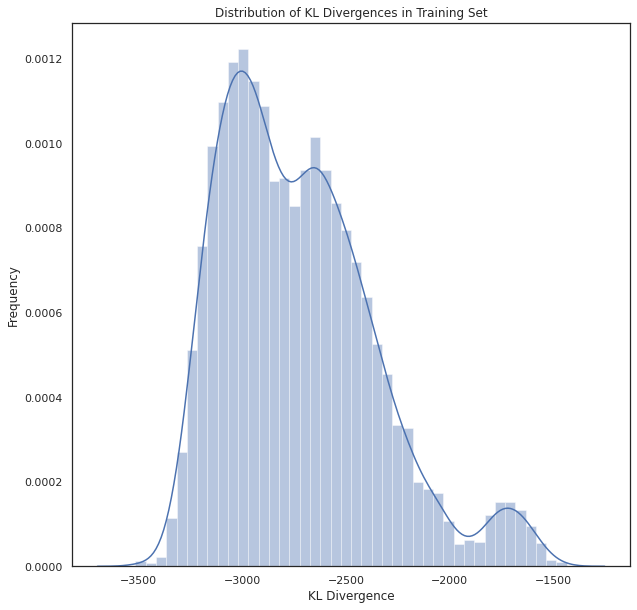

In [ ]:
fig, ax = plt.subplots()
sns.distplot(losses_trian_total, kde=True, ax=ax)
ax.set_title('Distribution of KL Divergences in Training Set')
ax.set_xlabel('KL Divergence')
ax.set_ylabel('Frequency')

plt.show()

## Save Model

In [ ]:
torch.save(model, "/content/drive/My Drive/Colab Notebooks/AMPs.VAE.27.10.pt")

## Load Model

In [ ]:
# Load
model = torch.load( "/content/drive/My Drive/Colab Notebooks/AMPs.VAE.27.10.pt")
model.eval()
model.state_dict()

# Test wiith AMPs/NonAMPs test set

AMPs_test_loader

In [ ]:

# Basically identify outliers by their large reconstruction loss as indicator
# of bad reconstruction ie outlier datapoint out of distribution.
with torch.no_grad():
  AMPS_losses_test = []
  for batch_idx, data in enumerate(AMPs_test_loader):
      recon_batch, mu, logvar = model(data)
      loss = loss_function(recon_batch, data, mu, logvar)
      AMPS_losses_test.append(loss.item() / len(data))
      #print(loss.item() / len(data))
print('Test mean:', np.mean(AMPS_losses_test))

Test mean: -3166.742414686552


Plot loss distribution after testing with unseen AMPS

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


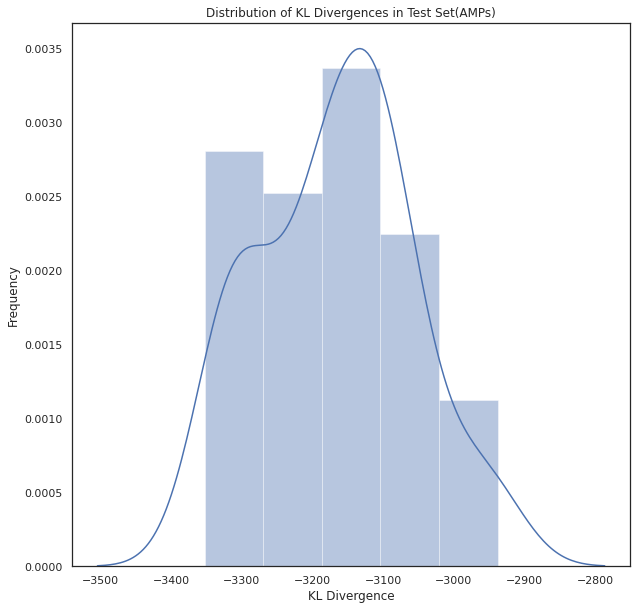

In [ ]:
fig, ax = plt.subplots()
sns.distplot(AMPS_losses_test, kde=True, ax=ax)
ax.set_title('Distribution of KL Divergences in Test Set(AMPs)')
ax.set_xlabel('KL Divergence')
ax.set_ylabel('Frequency')
plt.show()


NonAMPs_test_loader

In [ ]:

# Basically identify outliers by their large reconstruction loss as indicator
# of bad reconstruction ie outlier datapoint out of distribution.
with torch.no_grad():
  NonAMPs_losses_test = []
  for batch_idx, data in enumerate(NonAMPs_test_loader):
      recon_batch, mu, logvar = model(data)
      loss = loss_function(recon_batch, data, mu, logvar)
      NonAMPs_losses_test.append(loss.item() / len(data))
      #print(loss.item() / len(data))
print('Test mean:', np.mean(NonAMPs_losses_test))

Test mean: -2987.3428113731966


Plot loss distribution after testing with unseen NonAMPS

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


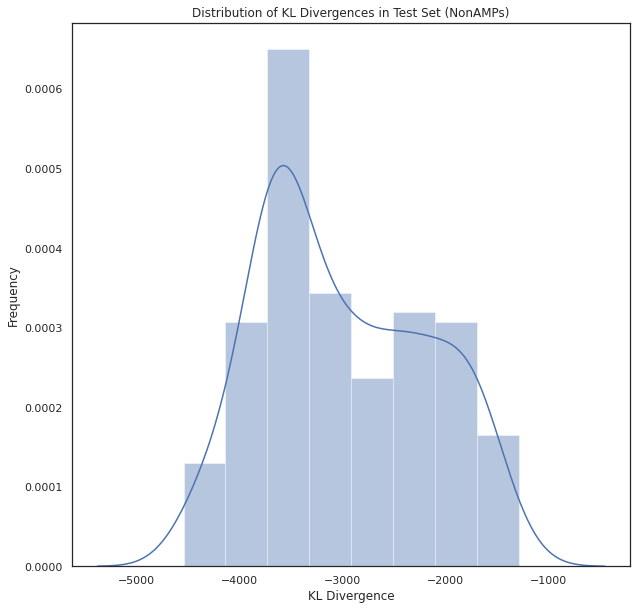

In [ ]:
fig, ax = plt.subplots()
sns.distplot(NonAMPs_losses_test, kde=True, ax=ax)
ax.set_title('Distribution of KL Divergences in Test Set (NonAMPs)')
ax.set_xlabel('KL Divergence')
ax.set_ylabel('Frequency')
plt.show()

## Visualize Results

Create Pandas of AMPs traning set and  AMPs/NonAMPs test set

In [ ]:

df_AMPs_losses_train = pd.DataFrame(kls, columns =['losses']) 
df_AMPs_losses_train['label'] = "AMPs_train"
df_AMPs_losses_train = df_AMPs_losses_train.sample(n = 200) 
df_AMPs_losses_train

,losses,label
7092,-2886.259062,AMPs_train
6409,-3100.841875,AMPs_train
146,-1544.575469,AMPs_train
3459,-2477.905313,AMPs_train
7145,-3149.651250,AMPs_train
...,...,...
7809,-3165.872812,AMPs_train
4293,-2850.537188,AMPs_train
227,-1878.120625,AMPs_train
3563,-2716.835938,AMPs_train


In [ ]:
df_AMPs_losses_test = pd.DataFrame(AMPS_losses_test, columns =['losses']) 
df_AMPs_losses_test['label'] = "AMPs_test"
df_AMPs_losses_test.head()

,losses,label
0,-3267.381250,AMPs_test
1,-3106.896875,AMPs_test
2,-2947.344062,AMPs_test
3,-3158.105000,AMPs_test
4,-3110.134062,AMPs_test


In [ ]:
df_NonAMPs_losses_test = pd.DataFrame(NonAMPs_losses_test, columns =['losses']) 
df_NonAMPs_losses_test['label'] = "NonAMPs_test"
df_NonAMPs_losses_test

,losses,label
0,-4355.570937,NonAMPs_test
1,-4374.681562,NonAMPs_test
2,-4539.010938,NonAMPs_test
3,-4360.749063,NonAMPs_test
4,-4488.401250,NonAMPs_test
...,...,...
203,-1494.740469,NonAMPs_test
204,-2744.969375,NonAMPs_test
205,-3436.904062,NonAMPs_test
206,-2310.429844,NonAMPs_test


Merge all togethers

In [ ]:
df_ = pd.concat([df_AMPs_losses_train,df_AMPs_losses_test, df_NonAMPs_losses_test], ignore_index=True)
df_

,losses,label
0,-2886.259062,AMPs_train
1,-3100.841875,AMPs_train
2,-1544.575469,AMPs_train
3,-2477.905313,AMPs_train
4,-3149.651250,AMPs_train
...,...,...
446,-1494.740469,NonAMPs_test
447,-2744.969375,NonAMPs_test
448,-3436.904062,NonAMPs_test
449,-2310.429844,NonAMPs_test


Swarm Plots

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


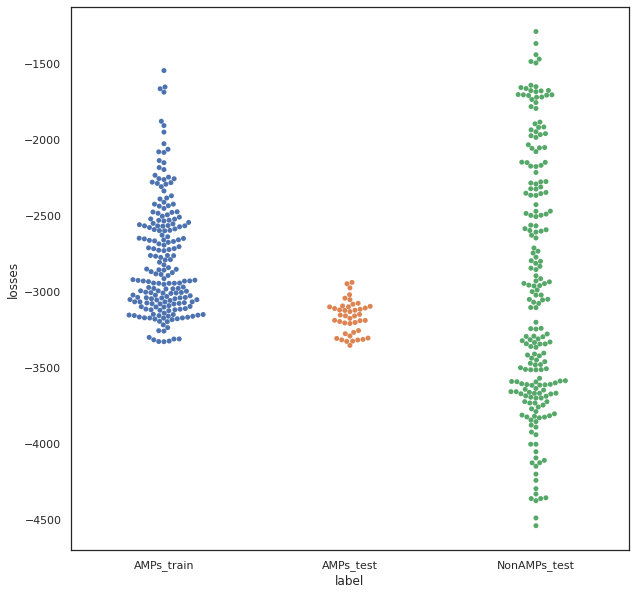

In [ ]:
sns.swarmplot(df_.label,df_.losses)

Box plot

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


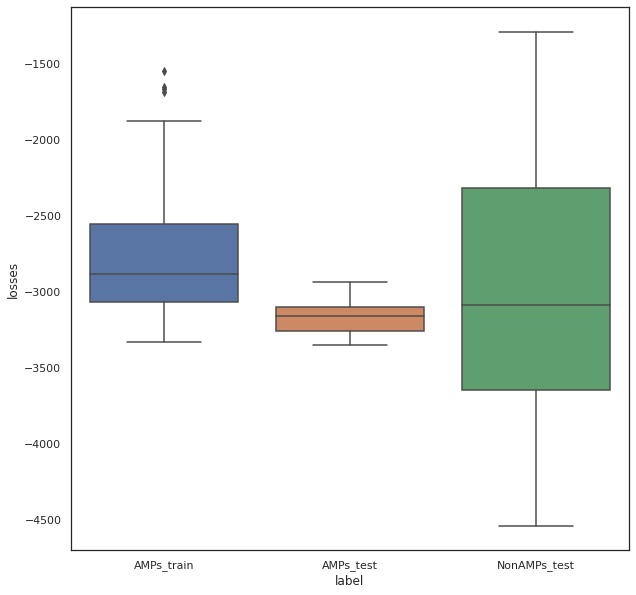

In [ ]:
sns.boxplot(df_.label,df_.losses)

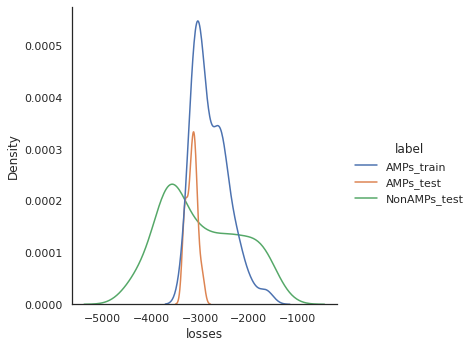

In [ ]:
sns.displot(df_ , x="losses", hue='label', kind="kde")

Scatter Plot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


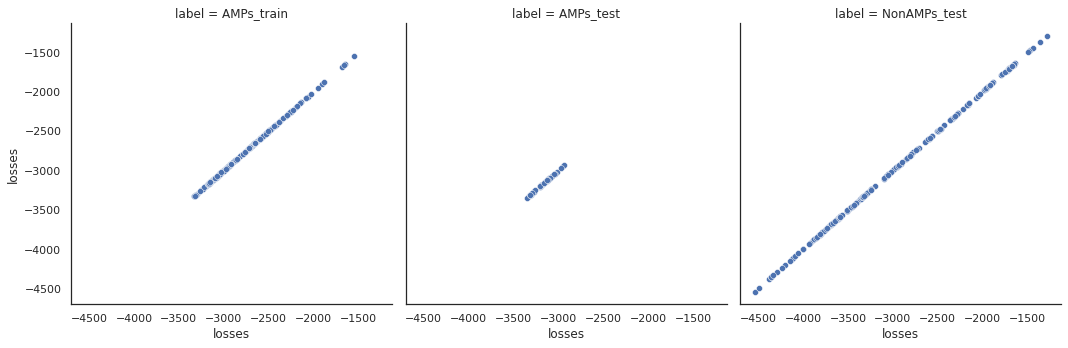

In [186]:
g = sns.FacetGrid(col='label',data=df_,legend_out=False,size=5)
g.map(sns.scatterplot,'losses','losses')

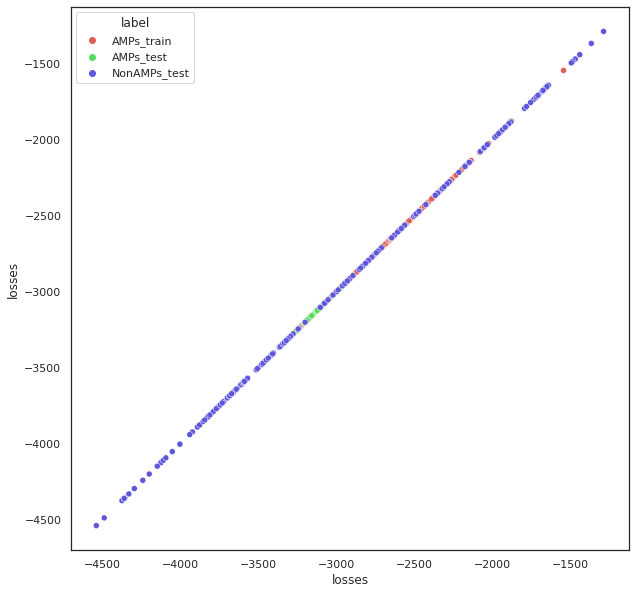

In [ ]:
sns.scatterplot(x='losses',y='losses',hue='label',palette=sns.color_palette("hls",3),data=df_,
               legend="full")
plt.show()

Joint Plot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2015: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


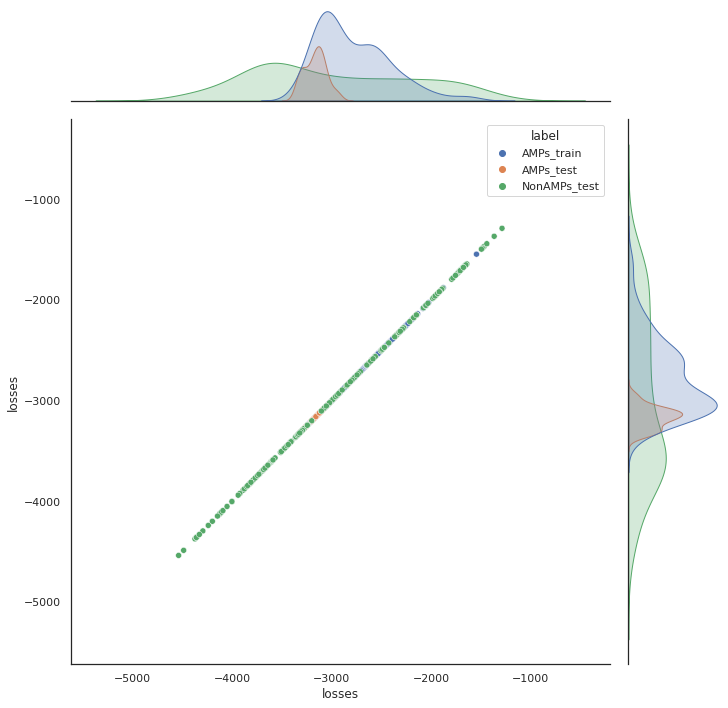

In [ ]:
#plot data with seaborn
sns.jointplot(data=df_, y="losses",
    x="losses", hue="label", size=10
)

Heatmap

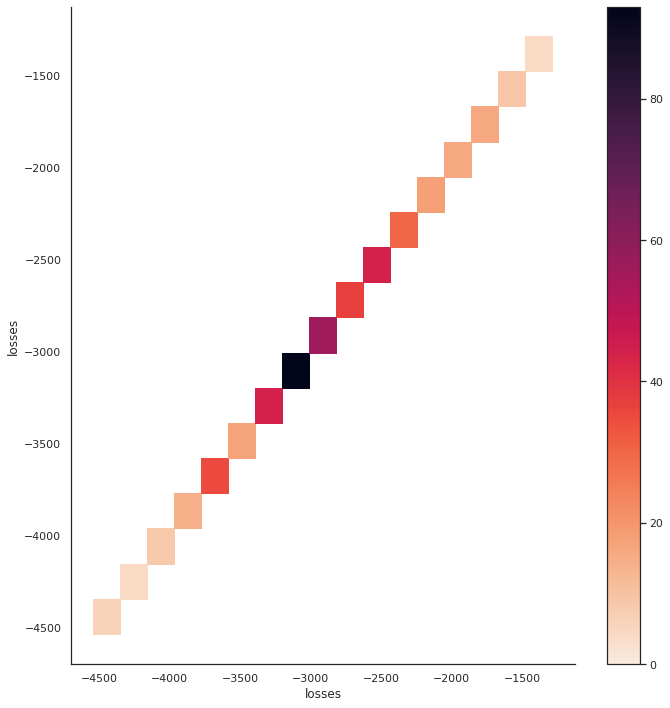

In [ ]:
cmap = sns.cm.rocket_r

sns.displot(df_, x="losses", y="losses",height=10, cbar=True, cmap = cmap)

# Threshold ??
To calculate threshold or certain cutoff level 

See mean and SD

In [ ]:
from scipy.stats import norm

NonAMPs

In [ ]:
mu, std = norm.fit(NonAMPs_losses_test)


In [ ]:
mu,std

(-2987.362861328125, 807.252911317152)

AMPs

In [ ]:
mu, std = norm.fit(AMPS_losses_test)
mu,std

(-3161.4446116658237, 106.97659135640419)

In [ ]:
mu, std = norm.fit(kls)
mu,std

(-2727.4916759031735, 371.0903074281573)